<a class="anchor" id="0"></a>
# **Featur correlation**

<a class="anchor" id="0.1"></a>
# **Table of Contents**


1. [Introduction to k Nearest Neighbours Algorithm](#1)
2. [k Nearest Neighbours intuition](#2)
3. [How to decide the number of neighbours in kNN](#3)
4. [Eager learners vs lazy learners](#4)



#### Libraries And Settings

In [17]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from datetime import timedelta

# Import Own modules
import context # it can oly import context.py when contained in the same folder as demmi.py
from demmi_ex_dict import demmi_ex, demmi_ex_short
from acceleration import put_margins_around_ex, resample, align_timestamp
from feature_dev import feature_development
from RUN_1_acceleration import EXERCISES
from paths import path_output

# Allow several outputs in same cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Settings
import warnings
warnings.filterwarnings('ignore')

# **2. Exploratory Data Analysis** <a class="anchor" id="2"></a>

[Table of Contents](#0.1)

a

In [18]:
# Load scores_ALL_ex
scores_ALL_ex = pd.read_csv('scores_ALL_ex_60pat.csv')  
counts = scores_ALL_ex.groupby(["Exercise", "Patient"])["BMI"].count() # enthält keine col 'Exertion'
df = scores_ALL_ex.groupby(["Exercise", "Patient"]).mean()
df = df.drop('DeMortonDay', 1) # drop col DeMortonDay, bc makes no sense
df["counts"] = counts # Shows how many counts were aggregated to calculate mean for each group (eg 4 obs).
df = df.reset_index() # ev nötig damit pairplot geht.. Muss hue-variable factor sein?
df.rename(columns={'Exercise':'Exercise_number'}, inplace=True)
df['Exercise'] = df['Exercise_number'].map(demmi_ex_short)
df['Patient'] = df['Patient'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Exercise_number  210 non-null    object 
 1   Patient          210 non-null    object 
 2   Std Dev of A     210 non-null    float64
 3   BMI              210 non-null    float64
 4   Kinetic energy   210 non-null    float64
 5   Max. Frequency   210 non-null    float64
 6   Exertion         210 non-null    float64
 7   counts           210 non-null    int64  
 8   Exercise         210 non-null    object 
dtypes: float64(5), int64(1), object(3)
memory usage: 14.9+ KB


In [19]:
df.shape # Dimensions 
df.head() # Print first 5 rows of df

(210, 9)

,Exercise_number,Patient,Std Dev of A,BMI,Kinetic energy,Max. Frequency,Exertion,counts,Exercise
0,12,1,30.817592,21.469150,2.318062e+05,1.675337,1.666667,3,12: Gehen
1,12,2,30.079820,26.370238,1.567620e+06,2.046280,0.500000,4,12: Gehen
2,12,3,39.282420,29.903029,7.254029e+06,2.421437,3.000000,5,12: Gehen
3,12,4,41.677283,20.061728,1.306585e+06,1.616928,-0.333333,6,12: Gehen
4,12,5,32.398952,27.016860,2.979716e+05,1.825213,1.000000,6,12: Gehen


In [20]:
# Descriptive statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Std Dev of A,210.0,59.444470,6.787361e+01,1.666787,19.582923,33.650465,52.207696,3.221087e+02
BMI,210.0,25.264578,4.321330e+00,16.423650,22.019503,25.101082,28.256990,3.820018e+01
Kinetic energy,210.0,789202.209329,3.427167e+06,0.000000,0.000000,6613.899083,153574.201667,4.055145e+07
Max. Frequency,210.0,2.407709,1.212328e+00,0.390886,1.664660,2.100745,2.846661,7.932976e+00
Exertion,210.0,0.427381,9.392854e-01,-1.800000,0.000000,0.200000,1.000000,3.000000e+00
counts,210.0,3.719048,1.435076e+00,1.000000,3.000000,4.000000,5.000000,6.000000e+00


In [21]:
# Descriptive statistics (of categorical variables)
df.describe(include=object).T

,count,unique,top,freq
Exercise_number,210,4,12,55
Patient,210,55,1,4
Exercise,210,4,12: Gehen,55


In [22]:
# Count NANs per feature
df.isnull().sum()

Exercise_number    0
Patient            0
Std Dev of A       0
BMI                0
Kinetic energy     0
Max. Frequency     0
Exertion           0
counts             0
Exercise           0
dtype: int64

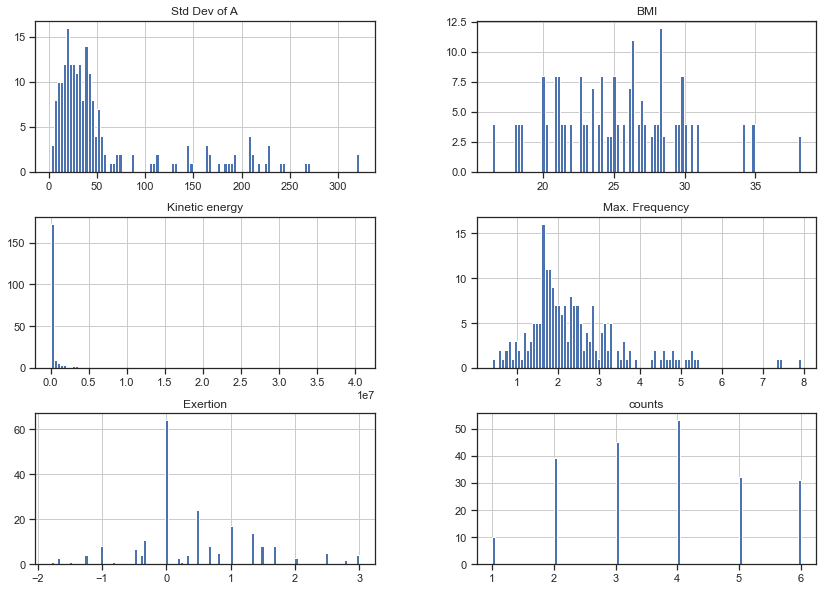

In [23]:
# Histograms of: age, avg_glucose_level, bmi
df[['Std Dev of A','BMI', 'Kinetic energy', 'Max. Frequency', 'Exertion', 'counts']].hist(bins=100, figsize=(14,10));

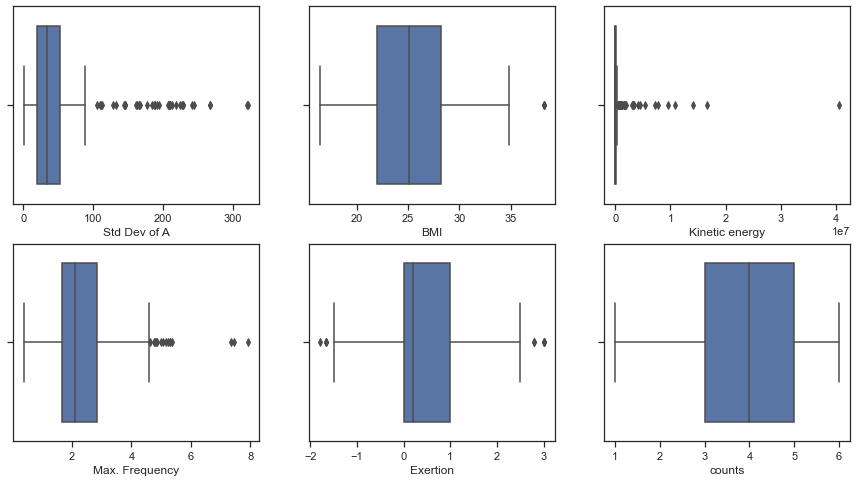

In [24]:
# Checking outliers
plt.figure(figsize=(15, 8))
plt.subplot(2,3,1)
sns.boxplot( x=df["Std Dev of A"] );
plt.subplot(2,3,2)
sns.boxplot( x=df["BMI"] );
plt.subplot(2,3,3)
sns.boxplot( x=df["Kinetic energy"] );
plt.subplot(2,3,4)
sns.boxplot( x=df["Max. Frequency"] );
plt.subplot(2,3,5)
sns.boxplot( x=df["Exertion"] );
plt.subplot(2,3,6)
sns.boxplot( x=df["counts"] );

# **1. Remove outliers** <a class="anchor" id="1"></a>
Above we saw that bmi has extreme outliers. The outliers that deviate more than 4 sd are excluded.


[Table of Contents](#0.1)

In [25]:
# calculate z-scores for bmi
z = np.abs(stats.zscore(df["Kinetic energy"]))
z
threshold = 2 # 4 sd

0      0.163029
1      0.227674
2      1.890855
3      0.151326
4      0.143677
         ...   
205    0.229399
206    0.230829
207    0.211477
208    0.229618
209    0.230805
Name: Kinetic energy, Length: 210, dtype: float64

In [26]:
outliers_i = np.where(z > threshold) # indices of outliers
# print(outliers_i)
outliers_count = sum(z > threshold)
print("Outliers to be excluded in 'Kinetic energy': ", outliers_count)

Outliers to be excluded in 'Kinetic energy':  6


In [27]:
# remove obs of bmi-outliers
df = df.loc[z < threshold,:] # subset obs, that are not bmi-outliers
#df = df.reset_index(drop=True)

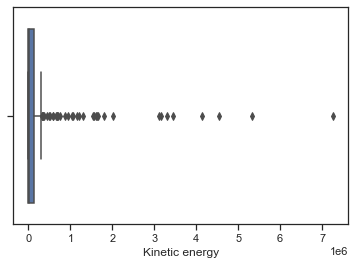

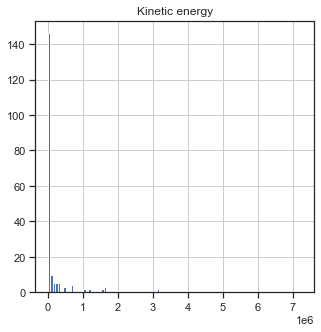

In [28]:
# Check new distribution of Kinetic energy
sns.boxplot( x=df["Kinetic energy"] );
df[['Kinetic energy']].hist(bins=100, figsize=(5,5));

# **1. Correlation** <a class="anchor" id="1"></a>

In [29]:
df = df.drop('counts', 1) # drop col counts

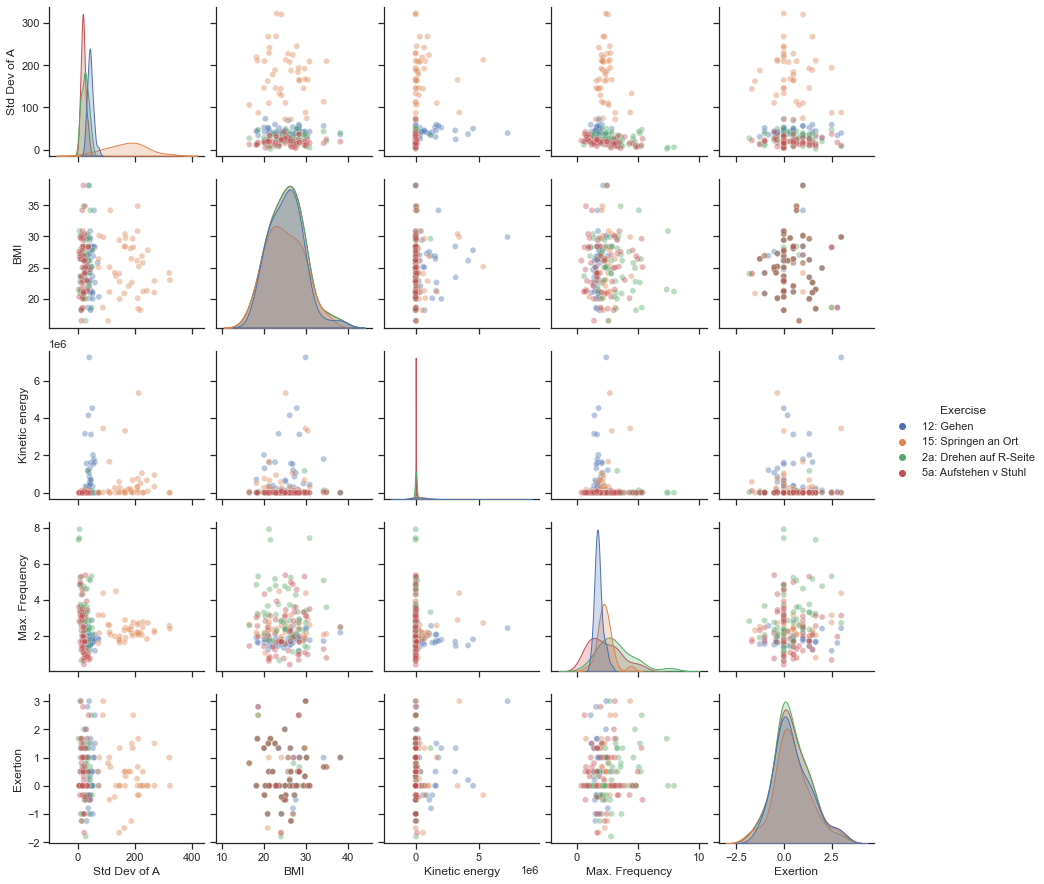

In [30]:
import seaborn as sns
sns.set_theme(style="ticks")

# by "Exercise"
sns.pairplot(df, hue="Exercise", plot_kws = { 'alpha': 0.4 })

path_save = Path(path_output, 'plots/corr_features/corr_features_HUE_exercise.png')
plt.savefig(path_save)

LinAlgError: singular matrix

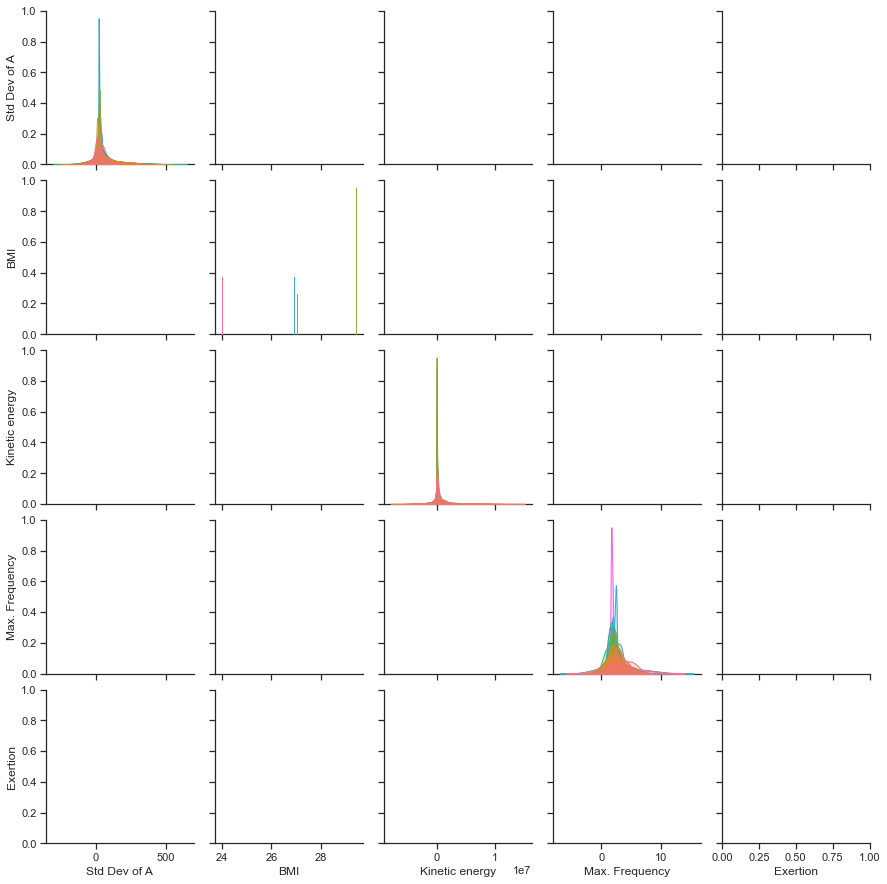

In [31]:
# by "Patient"
sns.pairplot(df, hue="Patient")
#path_save = Path(path_output, 'plots/corr_features/corr_features_HUE_patient.png')
#plt.savefig(path_save)

# KEINE AHNUNG WARUM, NACH DEM OUTLIER-REMOVAL DIESER PLOT NICHT MEHR FUNKTIONIERT.....

#### Pearson's Correlation heatmap between all features
Note: scale shoes only values between -0.5 and 0.5 (for better visibility)


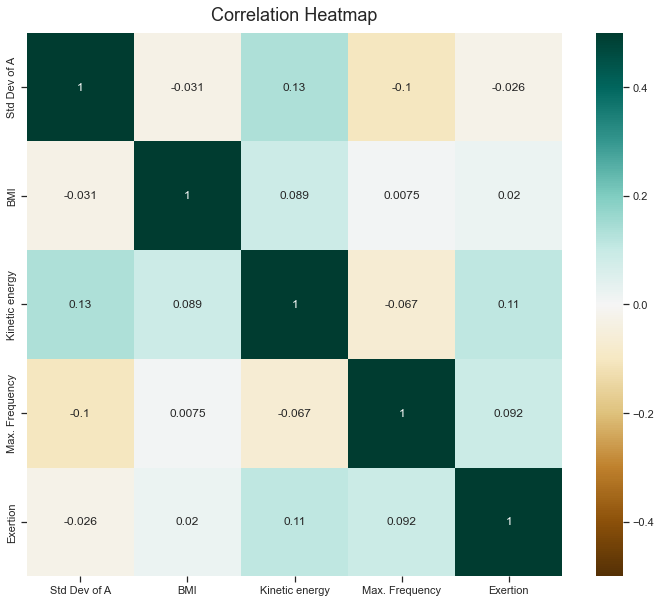

In [32]:
plt.figure(figsize=(12,10)) 
heatmap = sns.heatmap(df.corr(), vmin = -0.5, vmax=0.5,
            annot=True, cmap ='BrBG'); 
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

Interpretation:

In [33]:
df.corr()

,Std Dev of A,BMI,Kinetic energy,Max. Frequency,Exertion
Std Dev of A,1.000000,-0.030853,0.134385,-0.104786,-0.026051
BMI,-0.030853,1.000000,0.088845,0.007485,0.020430
Kinetic energy,0.134385,0.088845,1.000000,-0.066888,0.112044
Max. Frequency,-0.104786,0.007485,-0.066888,1.000000,0.091745
Exertion,-0.026051,0.020430,0.112044,0.091745,1.000000


# **3. Normalization (Scaling)** <a class="anchor" id="3"></a>
All features should be scaled for ML applications.


[Table of Contents](#0.1)


a

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

In [35]:
# Divide stroke df into its numerical and categorical features
X_num = df.select_dtypes(include=[float]) # subset of the 5 numerical features
X_cat = df.select_dtypes(include=[object]) # subset of the 2 categorical features: Exercise, Patient


In [36]:
X = StandardScaler().fit_transform(X_num) # output becomes: numpy-ndarray
# StandardScaler cannot guarantee balanced feature scales in the presence of outliers.
X

array([[-4.14218090e-01, -8.80837838e-01, -1.00830748e-01,
        -6.16084444e-01,  1.31693109e+00],
       [-4.25126232e-01,  2.72927976e-01,  1.34717247e+00,
        -3.12341695e-01,  7.01117593e-02],
       [-2.89063452e-01,  1.10458277e+00,  7.51116026e+00,
        -5.14874694e-03,  2.74186747e+00],
       ...,
       [-5.13718477e-01, -2.47662793e-01, -2.80385080e-01,
        -6.26194794e-01, -8.91720296e-01],
       [-3.96089668e-01, -5.59802211e-01, -3.47618850e-01,
        -1.29242979e+00, -4.64239382e-01],
       [-6.45897607e-01, -4.64570609e-02, -3.52019165e-01,
         5.86504510e-01, -4.64239382e-01]])

[Go to Top](#0)